# Predicción del abandono (BURNOUT) de empleados

## Carga de los datos

El primer paso a seguir es cargar los datos para poder trabajar sobre ellos y construir un modelo que prediga si un empleado va a abandonar la empresa.

In [1]:
import pandas as pd

df = pd.read_pickle('attrition_available_12.pkl')
#value_counts

#jobINvolment = df['JobInvolvement']
#print(jobINvolment.value_counts())

## Análisis exploratorio de datos

Ver las primeras filas del dataframe para tener una idea de cómo están estructurados los datos.

In [2]:
df.head()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,13.0,2.0,NaN,3.0,2.0,4.0,31.0,Yes,Travel_Frequently,...,0.0,Y,NaN,8.0,1.0,6.0,3,NaN,1.0,4.0
6,NaN,17.0,3.0,NaN,1.0,3.0,1.0,28.0,Yes,Travel_Rarely,...,2.0,Y,NaN,8.0,1.0,5.0,2,0.0,NaN,0.0
13,NaN,14.0,2.0,3.0,1.0,2.0,2.0,47.0,Yes,Non-Travel,...,1.0,Y,11.0,NaN,2.0,10.0,4,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,NaN,1.0,NaN,Yes,NaN,...,3.0,Y,14.0,8.0,1.0,19.0,2,1.0,0.0,NaN
30,9.662808,NaN,2.0,3.0,1.0,2.0,3.0,26.0,Yes,Travel_Rarely,...,2.0,Y,11.0,8.0,0.0,5.0,5,3.0,0.0,2.0


Debemos tener en cuenta que lo que queremos predecir es la columna '`attrition`', que mide si el empleado va a dejar el trabajo o no.

Ver los tipos de datos de las columnas

In [3]:
df.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours              float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany      

Contar el número de instancias y columnas

In [4]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  31


Ver si hay columnas constantes

In [5]:
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes: ", const_cols)


Columnas constantes:  ['EmployeeCount', 'Over18', 'StandardHours']


Hemos visto que las columnas constantes son las siguientes: *EmployeeCount, Over18, StandardHours*. Ya que estas columnas no van a aportar ninguna información útil al modelo, debemos eliminarlas. Ahora en vez de 31 columnas, tendremos 28.

In [6]:
df = df.drop(const_cols, axis=1)

In [7]:
df = df.drop('EmployeeID', axis=1)

Volvemos a mirar el numero de instancias y columnas

In [8]:
num_instances = len(df)
num_columns = len(df.columns)

print("Número de instancias: ", num_instances)
print("Número de columnas: ", num_columns)

Número de instancias:  4410
Número de columnas:  27


Ver los valores de las columnas constantes

In [9]:
missing_vals = df.isnull().sum() / len(df)
print("Proporción de valores faltantes: ")
print(missing_vals)

Proporción de valores faltantes: 
hrs                        0.211791
absences                   0.213152
JobInvolvement             0.169388
PerformanceRating          0.193197
EnvironmentSatisfaction    0.209524
JobSatisfaction            0.170522
WorkLifeBalance            0.008617
Age                        0.211791
Attrition                  0.000000
BusinessTravel             0.172336
Department                 0.186395
DistanceFromHome           0.000000
Education                  0.218594
EducationField             0.180952
Gender                     0.200454
JobLevel                   0.000000
JobRole                    0.216780
MaritalStatus              0.202041
MonthlyIncome              0.192517
NumCompaniesWorked         0.166440
PercentSalaryHike          0.209524
StockOptionLevel           0.170748
TotalWorkingYears          0.186848
TrainingTimesLastYear      0.000000
YearsAtCompany             0.172336
YearsSinceLastPromotion    0.183447
YearsWithCurrManager       0.1

## Preprocesamiento de los datos

En esta sección realizaremos el procesamiento de los valores faltantes y la transformación de los datos categóricos.

Parae ello, primero realizaremos la división de los datos en un conjunto de entrenamiento y test

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import set_config


X = df.drop('Attrition', axis=1) 
y = df['Attrition']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=0, stratify=y)
set_config(transform_output="pandas")


A continuación, se procederá a transformar los datos

In [11]:
# Primero importamos las librerías necesarias
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


# Definimos las columnas que son numéricas y las que son categóricas
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# Imprimimos cuñales de estas columnas son numéricas y cuáles categóricas
print(f"Columnas numéricas: {list(numerical_features)}")
print(f"Columnas categóricas: {list(categorical_features)}")


# Definimos las transformaciones que se aplicarán a las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Definimos las transformaciones que se aplicarán a las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore'))
])


# Pre-procesador "global"
processor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


processor.fit(X_train)
# Realizamos la transformación.
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)
X_train_processed.head()


Columnas numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Columnas categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']


,num__hrs,num__absences,num__JobInvolvement,num__PerformanceRating,num__EnvironmentSatisfaction,num__JobSatisfaction,num__WorkLifeBalance,num__Age,num__DistanceFromHome,num__Education,...,cat__JobRole_Laboratory Technician,cat__JobRole_Manager,cat__JobRole_Manufacturing Director,cat__JobRole_Research Director,cat__JobRole_Research Scientist,cat__JobRole_Sales Executive,cat__JobRole_Sales Representative,cat__MaritalStatus_Divorced,cat__MaritalStatus_Married,cat__MaritalStatus_Single
473,8.047625,8.000000,3.0,3.0,4.0,1.000000,3.0,20.000000,2.0,2.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
66,5.762560,17.000000,3.0,3.0,4.0,4.000000,3.0,30.000000,13.0,3.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1256,6.269080,20.000000,1.0,3.0,3.0,2.719248,3.0,30.000000,1.0,2.89895,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
87,7.302132,12.000000,2.0,4.0,3.0,4.000000,2.0,23.000000,20.0,4.00000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
703,8.932334,12.617455,2.0,3.0,3.0,3.000000,3.0,36.604003,1.0,2.00000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Comprobamos si se ha hecho bien y no hay missing values. Como se puede comprobar, se han transformado los datos de manera satisfactoria y ya no hay missing values y todos los datos se han convertido a numéricos mediante el uso de la técnica `OneHotEnconding`.

In [12]:
print(f"Numero de valores valtantes de entrenamiento: {np.isnan(X_train_processed).sum()}")
print(f"Numero de valores valtantes de test: {np.isnan(X_test_processed).sum()}")

Numero de valores valtantes de entrenamiento: num__hrs                                  0
num__absences                             0
num__JobInvolvement                       0
num__PerformanceRating                    0
num__EnvironmentSatisfaction              0
num__JobSatisfaction                      0
num__WorkLifeBalance                      0
num__Age                                  0
num__DistanceFromHome                     0
num__Education                            0
num__JobLevel                             0
num__MonthlyIncome                        0
num__NumCompaniesWorked                   0
num__PercentSalaryHike                    0
num__StockOptionLevel                     0
num__TotalWorkingYears                    0
num__TrainingTimesLastYear                0
num__YearsAtCompany                       0
num__YearsSinceLastPromotion              0
num__YearsWithCurrManager                 0
cat__BusinessTravel_Non-Travel            0
cat__BusinessTravel_Travel_Fre

## Balanceamiento de la clase   

Para saber si el conjunto de datos está desbalanceado, primeramente contaremos el número de observaciones en cada clase de la variable objetivo

In [13]:
# Contar el número de observaciones en cada clase de la variable objetivo
counts = df['Attrition'].value_counts()

print(counts)

No     3699
Yes     711
Name: Attrition, dtype: int64


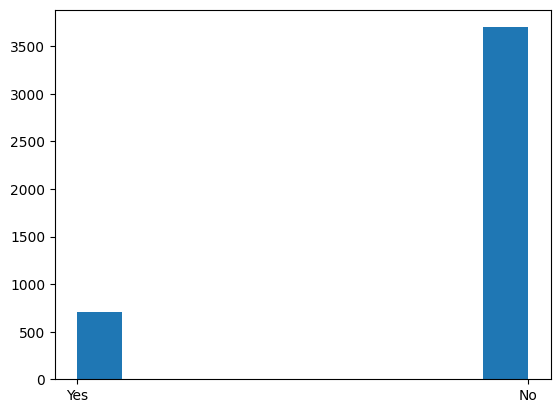

In [14]:
import matplotlib.pyplot as plt

# Crear un histograma de la variable objetivo
plt.hist(df['Attrition'])
plt.show()


Para estudiarlo más en profundidad, calculamos la proporción de observaciones en cada conjunto de entrenamiento y test.

In [15]:
N_SAMPLES_NEG = 3699
N_SAMPLES_POS = 711


In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
# Vamos a comenzar realizando una división train/test "normal".
X_train_no_strat, X_test_no_strat, y_train_no_strat, y_test_no_strat = train_test_split(X, y, test_size=1/3)


# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train_no_strat=="Yes") / len(y_train_no_strat)
n_pos_test_pct = np.sum(y_test_no_strat=="Yes") / len(y_test_no_strat)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.7 % de instancias positivas en train.
Hay un 14.9 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Basándonos en los resultados obtenidos, podemos afirmar que los datos están ligeramente desbalanceados. Al analizar la proporción de instancias positivas en el conjunto de train y test, observamos que esta proporción es de alrededor del 16%, lo que significa que la clase minoritaria está ligeramente subrepresentada, por lo que procedemos a hacer una `división estratificada`

Aunque en términos estrictos se puede considerar que los datos están desbalanceados, el desequilibrio no es extremo. En este caso, es posible que no se requieran técnicas de muestreo especializadas para equilibrar la distribución de clases y que un modelo de aprendizaje automático pueda entrenarse con éxito en este conjunto de datos.






In [17]:

# Comprobemos ahora la distribución de las clases.
n_pos_pct = N_SAMPLES_POS / (N_SAMPLES_POS + N_SAMPLES_NEG)
n_pos_train_pct = np.sum(y_train=="Yes") / len(y_train)
n_pos_test_pct = np.sum(y_test=="Yes") / len(y_test)

print(f"Hay un {100 * n_pos_train_pct:.1f} % de instancias positivas en train.")
print(f"Hay un {100 * n_pos_test_pct:.1f} % de instancias positivas en test.")
print(f"Hay un {100 * n_pos_pct:.1f} % de instancias positivas en total.")

Hay un 16.1 % de instancias positivas en train.
Hay un 16.1 % de instancias positivas en test.
Hay un 16.1 % de instancias positivas en total.


Por lo tanto, se trata de un problema de clasificación binaria ya que el objetivo es predecir si los trabajadores abandonarán su puesto de trabajo o no, es decir, la variable de salida se trata de una variable categórica (*si* o *no*)

## Dummy classifier

In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report



# Crear el dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_processed, y_train)

# Realizar predicciones en los datos de prueba
y_pred = dummy.predict(X_test_processed)

# Calcular las métricas de clasificación


In [19]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
print("##### F1 ####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred))




##### F1 ####
0.0
##### BALANCED ACCURACY ####
0.5
##### CONFUSION MATRIX ####
[[1233    0]
 [ 237    0]]


Como era de esperar, la métrica de balanced accurary da como resultado el peor valor posible dentro de los valores aceptados, es decir, la media. En cuanto al F1_score, debido a que el F1 score está predicido por un dummy classifier, puede indicar que el conjunto de datos es fácil de clasificar. Sin embargo es importante analizar otras métricas para obtener una evaluación más completa del desempeño del modelo, por lo que además se utilizan más métricas como confusion_matrix, balanced_accurary...

## Método base: Logistic Regression

El método de `Regresión Logística` se utiliza para predecir la probabilidad de pertenencia a una de dos clases posibles, en este caso sería Sí o No de la columna que queremos predecir (Attrition). El modelo de regresión logística se ajusta a los datos de entrenamiento mediante la minimización de una función de costo que mide la discrepancia entre las probabilidades predichas por el modelo y las etiquetas reales de los datos de entrenamiento. Una vez que el modelo se ha ajustado a los datos de entrenamiento, se puede utilizar para hacer predicciones sobre datos nuevos o no vistos anteriormente.

En este caso, es recomendable escalar los datos porque los coeficientes del modelo se calculan mediante la minimización de una función de costo. 

In [30]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Normalizar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Entrenar el modelo de regresión logística
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Realizar predicciones en los datos de prueba
y_pred = logreg.predict(X_test_scaled)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred))


##### F1 ####
0.22972972972972974
##### BALANCED ACCURACY ####
0.5615920827045284
##### CONFUSION MATRIX ####
[[1208   25]
 [ 203   34]]


## Método avanzado: Gradient Boosting

Se ha eligido como método avanzado de boosting, el tipo Gradient, debido a que puede que funcione mejor términos de precisión o capacidad de generalización para este problema.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold


# Definir los parámetros a ajustar y sus valores posibles
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 4]
}

# Crear un objeto de GradientBoostingClassifier
model = GradientBoostingClassifier()

# Crear un objeto de StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Crear un objeto de GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='balanced_accuracy')

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_processed, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

print(best_params)



{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [22]:
from sklearn.ensemble import GradientBoostingClassifier


# Crear un objeto de GradientBoostingClassifier
model = GradientBoostingClassifier(max_depth=4, min_samples_split=2, n_estimators=150)
model.fit(X_train_processed, y_train)
y_pred= model.predict(X_test_processed)

print("##### F1 #####")
print(f1_score(y_test, y_pred, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY #####")
print(balanced_accuracy_score(y_test, y_pred))
print("##### CONFUSION MATRIX #####")
print(confusion_matrix(y_test, y_pred))


##### F1 #####
0.5397727272727273
##### BALANCED ACCURACY #####
0.692311640847167
##### CONFUSION MATRIX #####
[[1213   20]
 [ 142   95]]


## Método avanzado: Xgboost Gradient

In [23]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_train_transformed = le.fit_transform(y_train)
y_test_transformed= le.fit_transform(y_test)


#Crear un objeto DMatrix a partir de los datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train_processed, label=y_train_transformed)
dtest = xgb.DMatrix(X_test_processed, label=y_test_transformed)

# Definir los hiperparámetros del modelo y los valores a explorar en la búsqueda por grilla
params = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Crear un objeto XGBoost clasificador
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Realizar la búsqueda por grilla
grid_search = GridSearchCV(xgb_model, param_grid=params, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
grid_search.fit(X_train_processed, y_train_transformed)

# Obtener los mejores hiperparámetros encontrados por la búsqueda por grilla
best_params = grid_search.best_params_

print(best_params)



{'colsample_bytree': 1.0, 'max_depth': 5, 'min_child_weight': 1}


In [35]:
import xgboost as xgb
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix

# Crear un objeto DMatrix a partir de los datos de entrenamiento y prueba
dtrain = xgb.DMatrix(X_train_processed, label=y_train_transformed)
dtest = xgb.DMatrix(X_test_processed, label=y_test_transformed)

# Definir los hiperparámetros del modelo
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'min_child_weight': 1,
    'colsample_bytree': 1.0,
}

# Entrenar el modelo
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Realizar predicciones en los datos de prueba
y_pred = xgb_model.predict(dtest)
y_pred = [round(value) for value in y_pred]

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred))


##### F1 ####
0.6402116402116402
##### BALANCED ACCURACY ####
0.7471639615222725
##### CONFUSION MATRIX ####
[[1213   20]
 [ 116  121]]


# Selección de atributos

En este punto se realizará una selección de los atributos para saber qué atributos son más importantes. Además, se comprobará el resultado obtenido con los métodos utilizados anteriormente para ver si ha habido alguna mejoría.

### Logistic Regression

Primero hay que calcular un valor de K el cual tenga sentido para seguir prediciendo un buen modelo sin tener en cuenta atributos reduntantes.

k=1, f1_score=0.0, balanced_accuracy=0.5
k=2, f1_score=0.0, balanced_accuracy=0.5
k=3, f1_score=0.0, balanced_accuracy=0.5
k=4, f1_score=0.06374501992031871, balanced_accuracy=0.5144445471064708
k=5, f1_score=0.07936507936507936, balanced_accuracy=0.5190694713932263
k=6, f1_score=0.07905138339920947, balanced_accuracy=0.5186639563891712
k=7, f1_score=0.1149425287356322, balanced_accuracy=0.5279959345837568
k=8, f1_score=0.15671641791044777, balanced_accuracy=0.5402486474278029
k=9, f1_score=0.15671641791044777, balanced_accuracy=0.5402486474278029
k=10, f1_score=0.16849816849816848, balanced_accuracy=0.5432515116983379
k=11, f1_score=0.17454545454545456, balanced_accuracy=0.544955701335633
k=12, f1_score=0.19999999999999998, balanced_accuracy=0.5529890048969787
k=13, f1_score=0.19999999999999998, balanced_accuracy=0.5529890048969787
k=14, f1_score=0.19999999999999998, balanced_accuracy=0.5529890048969787
k=15, f1_score=0.1678832116788321, balanced_accuracy=0.5428459966942828
k=16, f1_s

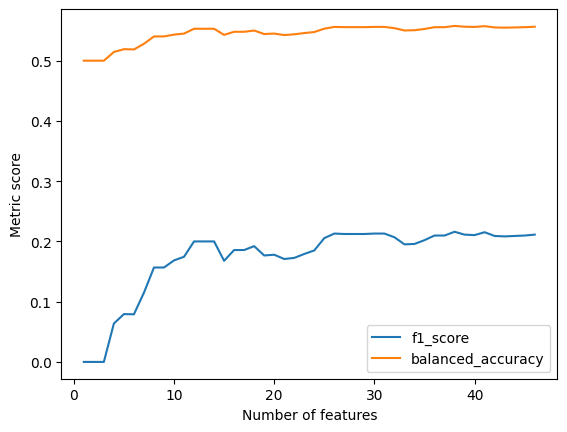

In [108]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif)
logreg = LogisticRegression()

pipe_select_logreg = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('logreg', logreg)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_logreg.fit(X_train_processed, y_train)
    y_pred_logreg = pipe_select_logreg.predict(X_test_processed)
    f1 = f1_score(y_test, y_pred_logreg, average='binary', pos_label='Yes')
    balanced_acc = balanced_accuracy_score(y_test, y_pred_logreg)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
    print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()

Como se puede apreciar en el gráfico, a partir de 14 atributos se puede observar que los valores para f1 score y balanced se empiezan a estabilizar.

In [109]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
logreg = LogisticRegression()
# Seleccionar los 10 atributos más importantes usando SelectKBest y f_classif
selector = SelectKBest(score_func=f_classif, k=14)


pipe_select_scale_log_reg = Pipeline([
    ('scale', scaler),
    ('select', selector),
    ('logreg', logreg)
])

pipe_select_scale_log_reg.fit(X_train_processed, y_train)

pipe_select_scale_log_reg.named_steps

{'scale': StandardScaler(),
 'select': SelectKBest(k=14),
 'logreg': LogisticRegression()}

In [110]:
import numpy as np

print(f"Features selected: {pipe_select_scale_log_reg.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_scale_log_reg.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_scale_log_reg.named_steps['scale'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_scale_log_reg.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True False False False  True  True  True  True False False False False
 False False False  True  True  True False  True False  True False False
 False False  True False False False False False False False False False
 False False False False False False False  True  True  True]
Locations where features selected: (array([ 0,  4,  5,  6,  7, 15, 16, 17, 19, 21, 26, 43, 44, 45]),)
Feature names after selection: ['num__hrs' 'num__EnvironmentSatisfaction' 'num__JobSatisfaction'
 'num__WorkLifeBalance' 'num__Age' 'num__TotalWorkingYears'
 'num__TrainingTimesLastYear' 'num__YearsAtCompany'
 'num__YearsWithCurrManager' 'cat__BusinessTravel_Travel_Frequently'
 'cat__EducationField_Human Resources' 'cat__MaritalStatus_Divorced'
 'cat__MaritalStatus_Married' 'cat__MaritalStatus_Single']


Evaluación del modelo

In [111]:
y_pred_logreg = pipe_select_scale_log_reg.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test, y_pred_logreg, average='binary', pos_label='Yes'))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test, y_pred_logreg))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test, y_pred_logreg))

##### F1 ####
0.21602787456445993
##### BALANCED ACCURACY ####
0.5576960588048087
##### CONFUSION MATRIX ####
[[1214   19]
 [ 206   31]]


### Gradient Boosting

Calculamos un valor de K con sentido

k=1, f1_score=0.07874015748031496, balanced_accuracy=0.518258441385116
k=2, f1_score=0.19867549668874174, balanced_accuracy=0.549098114098576
k=3, f1_score=0.23411371237458195, balanced_accuracy=0.5628907573377684
k=4, f1_score=0.255192878338279, balanced_accuracy=0.5676029443469155
k=5, f1_score=0.29429429429429427, balanced_accuracy=0.5843163222355683
k=6, f1_score=0.3058823529411765, balanced_accuracy=0.5890233761433984
k=7, f1_score=0.3567251461988304, balanced_accuracy=0.6108493229439362
k=8, f1_score=0.37426900584795314, balanced_accuracy=0.6183949818801523
k=9, f1_score=0.375, balanced_accuracy=0.618312852259078
k=10, f1_score=0.36734693877551017, balanced_accuracy=0.6154742472306918
k=11, f1_score=0.38953488372093026, balanced_accuracy=0.6251296108082581
k=12, f1_score=0.4068767908309455, balanced_accuracy=0.6331629143696038
k=13, f1_score=0.4127906976744186, balanced_accuracy=0.6351904893898797
k=14, f1_score=0.42441860465116277, balanced_accuracy=0.6402209286806904
k=15, f1_s

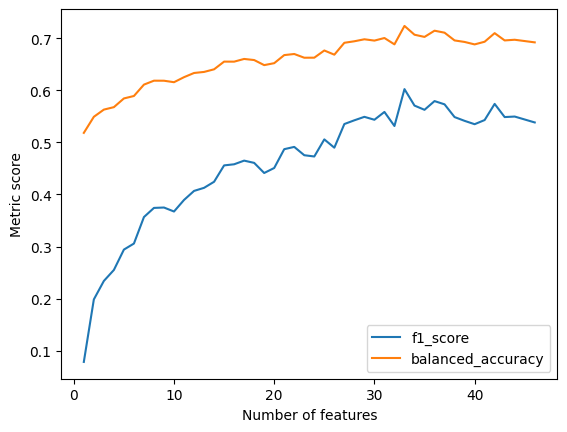

In [97]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif)
grad_boosting = GradientBoostingClassifier(max_depth=4, min_samples_split=2, n_estimators=150)

pipe_select_gradboost = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('gradient', grad_boosting)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_gradboost.fit(X_train_processed, y_train_transformed)
    y_pred_grad = pipe_select_gradboost.predict(X_test_processed)
    f1 = f1_score(y_test_transformed, y_pred_grad, average='binary', pos_label=1)
    balanced_acc = balanced_accuracy_score(y_test_transformed, y_pred_grad)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
    print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()

In [123]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()
selector = SelectKBest(f_classif, k=25)
grad_boosting = GradientBoostingClassifier(max_depth=4, min_samples_split=2, n_estimators=150)

pipe_select_gradboost = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('gradient', grad_boosting)
])

pipe_select_gradboost.fit(X_train_processed, y_train_transformed)

pipe_select_gradboost.named_steps


{'scaler': MinMaxScaler(),
 'select': SelectKBest(k=25),
 'gradient': GradientBoostingClassifier(max_depth=4, n_estimators=150)}

In [124]:
import numpy as np

print(f"Features selected: {pipe_select_gradboost.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_gradboost.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_gradboost.named_steps['scaler'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_gradboost.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True  True  True False  True  True  True  True False False False False
  True False False  True  True  True  True  True  True  True  True  True
 False False  True False False False False  True False False  True False
 False False  True False  True False False  True  True  True]
Locations where features selected: (array([ 0,  1,  2,  4,  5,  6,  7, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       26, 31, 34, 38, 40, 43, 44, 45]),)
Feature names after selection: ['num__hrs' 'num__absences' 'num__JobInvolvement'
 'num__EnvironmentSatisfaction' 'num__JobSatisfaction'
 'num__WorkLifeBalance' 'num__Age' 'num__NumCompaniesWorked'
 'num__TotalWorkingYears' 'num__TrainingTimesLastYear'
 'num__YearsAtCompany' 'num__YearsSinceLastPromotion'
 'num__YearsWithCurrManager' 'cat__BusinessTravel_Non-Travel'
 'cat__BusinessTravel_Travel_Frequently'
 'cat__BusinessTravel_Travel_Rarely' 'cat__Department_Human Resources'
 'cat__EducationField_Human Resources'
 'cat__EducationField_Techni

Evaluación del modelo

In [125]:
y_pred_grad = pipe_select_gradboost.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred_grad, average='binary', pos_label=1))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred_grad))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred_grad))

##### F1 ####
0.47398843930635837
##### BALANCED ACCURACY ####
0.6620468754812283
##### CONFUSION MATRIX ####
[[1206   27]
 [ 155   82]]


## XGB

k=1, f1_score=0.07874015748031496, balanced_accuracy=0.518258441385116
k=2, f1_score=0.17508417508417512, balanced_accuracy=0.5410648105372304
k=3, f1_score=0.2337662337662338, balanced_accuracy=0.5617563419466773
k=4, f1_score=0.27011494252873564, balanced_accuracy=0.5732031578839303
k=5, f1_score=0.3468834688346883, balanced_accuracy=0.6074460767706633
k=6, f1_score=0.3687150837988827, balanced_accuracy=0.6169371811060806
k=7, f1_score=0.4065934065934066, balanced_accuracy=0.6346258482449927
k=8, f1_score=0.416, balanced_accuracy=0.6402260617820075
k=9, f1_score=0.42048517520215634, balanced_accuracy=0.641848121798228
k=10, f1_score=0.43915343915343913, balanced_accuracy=0.6515856149968688
k=11, f1_score=0.44686648501362397, balanced_accuracy=0.6535310603960701
k=12, f1_score=0.4426229508196721, balanced_accuracy=0.6514213557547199
k=13, f1_score=0.448, balanced_accuracy=0.6553173796544396
k=14, f1_score=0.4712328767123288, balanced_accuracy=0.6644029689858019
k=15, f1_score=0.484042

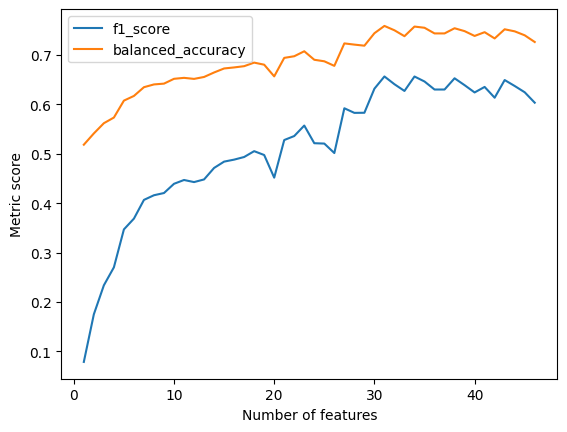

In [127]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
selector = SelectKBest(f_classif)
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=150)

pipe_select_xgb = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('xgb', xgb_clf)
])

# Listas para guardar los resultados de las métricas
f1_scores = []
balanced_accuracies = []

# Probar diferentes valores de k
for k in range(1, X_train_processed.shape[1] + 1):
    selector.set_params(k=k)
    pipe_select_xgb.fit(X_train_processed, y_train_transformed)
    y_pred_xgb = pipe_select_xgb.predict(X_test_processed)
    f1 = f1_score(y_test_transformed, y_pred_xgb, average='binary', pos_label=1)
    balanced_acc = balanced_accuracy_score(y_test_transformed, y_pred_xgb)
    f1_scores.append(f1)
    balanced_accuracies.append(balanced_acc)
    print(f"k={k}, f1_score={f1}, balanced_accuracy={balanced_acc}")

# Graficar los resultados
plt.plot(range(1, X_train_processed.shape[1] + 1), f1_scores, label="f1_score")
plt.plot(range(1, X_train_processed.shape[1] + 1), balanced_accuracies, label="balanced_accuracy")
plt.xlabel("Number of features")
plt.ylabel("Metric score")
plt.legend()
plt.show()



In [128]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
selector = SelectKBest(f_classif, k=31)
xgb_clf = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=150)

pipe_select_xgb = Pipeline([
    ('scaler', scaler),
    ('select', selector),
    ('xgb', xgb_clf)
])

pipe_select_xgb.fit(X_train_processed, y_train_transformed)

pipe_select_xgb.named_steps


{'scaler': MinMaxScaler(),
 'select': SelectKBest(k=31),
 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...)}

In [129]:
import numpy as np

print(f"Features selected: {pipe_select_xgb.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(pipe_select_xgb.named_steps['select'].get_support())}")

feature_names_before_selection = pipe_select_xgb.named_steps['scaler'].get_feature_names_out()
print(f"Feature names after selection: {pipe_select_xgb.named_steps['select'].get_feature_names_out(feature_names_before_selection)}")

Features selected: [ True  True  True  True  True  True  True  True  True  True False  True
  True False False  True  True  True  True  True  True  True  True  True
  True False  True False False False False  True False False  True False
 False False  True False  True False  True  True  True  True]
Locations where features selected: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 26, 31, 34, 38, 40, 42, 43, 44, 45]),)
Feature names after selection: ['num__hrs' 'num__absences' 'num__JobInvolvement' 'num__PerformanceRating'
 'num__EnvironmentSatisfaction' 'num__JobSatisfaction'
 'num__WorkLifeBalance' 'num__Age' 'num__DistanceFromHome'
 'num__Education' 'num__MonthlyIncome' 'num__NumCompaniesWorked'
 'num__TotalWorkingYears' 'num__TrainingTimesLastYear'
 'num__YearsAtCompany' 'num__YearsSinceLastPromotion'
 'num__YearsWithCurrManager' 'cat__BusinessTravel_Non-Travel'
 'cat__BusinessTravel_Travel_Frequently'
 'cat__BusinessTravel_Trav

In [130]:
y_pred_xgb = pipe_select_xgb.predict(X_test_processed)

# Calcular las métricas de clasificación
print("##### F1 ####")
print(f1_score(y_test_transformed, y_pred_xgb, average='binary', pos_label=1))
print("##### BALANCED ACCURACY ####")
print(balanced_accuracy_score(y_test_transformed, y_pred_xgb))
print("##### CONFUSION MATRIX ####")
print(confusion_matrix(y_test_transformed, y_pred_xgb))

##### F1 ####
0.6563307493540053
##### BALANCED ACCURACY ####
0.7586056443582083
##### CONFUSION MATRIX ####
[[1210   23]
 [ 110  127]]
